In [1]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

In [4]:
# Models
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression

# tsfresh functions
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

In [5]:
# ForecastingModdel class
class ForecastingModel:
    
    """
    Forecasting model, based on tsfresh feature extraction
    """
    
    def __init__(self, model, params):
        
        """
        Args:
            model: model with fit and predict methods
            parameters: None or list        
        """
        
        self.model = model
        self.params = params
        
    def fit(self, y_train, max_timeshift = 10, rolling_direction = 1):
        
        """
        Method to fit model
        Args:
            y (pd.Series): time series to train 
        """
        
        self.y_train = y_train
        
        self.max_timeshift = max_timeshift
        self.rolling_direction = rolling_direction
        
        df_shift, y = make_forecasting_frame(np.append(self.y_train, 0), kind = "price", 
                            max_timeshift = self.max_timeshift, rolling_direction = self.rolling_direction)
        
        self.X_train = extract_features(df_shift, column_id="id", column_sort="time", 
                                        column_value="value", impute_function=impute, show_warnings=False)
        
        self.X_train.dropna(axis = 1, inplace = True)
        
        self.model.fit(self.X_train[: -1: 1], self.y_train[1: : 1])
        
        pass
    
    def predict(self, forecast_horizont):
        
        """
        Predicting values on the next forecast_horizont values
        """
        
        try:
            y_pred = self.model.predict(self.X_train.iloc[-1][None, :])
        
        except:
            
            print("Model is not fitted yet. Call fit method!")
            return None
        
        y_train = np.append(self.y_train, y_pred)
        
        for it in range(1, forecast_horizont):
            
            df_shift, y = make_forecasting_frame(np.append(y_train, 0), kind = "price", 
                            max_timeshift = self.max_timeshift, rolling_direction = self.rolling_direction)
        
            X_train = extract_features(df_shift, column_id="id", column_sort="time", 
                    column_value="value", impute_function=impute, show_warnings=False)
        
            X_train.dropna(axis = 1, inplace = True)
            
            self.model.fit(X_train.iloc[: -1: 1], y_train[1: : 1])
            y_pred = self.model.predict(X_train.iloc[-1][None, :])
            y_train = np.append(y_train, y_pred)
        
        return y_train[self.y_train.shape[0]: : 1]
        

# Loading Data

In [7]:
data = pd.read_csv('AirPassengers.csv', usecols=[1])

In [8]:
data.columns = ["value"]
print(data.shape)
data.head(5)

(144, 1)


,value
0,112
1,118
2,132
3,129
4,121


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 1 columns):
value    144 non-null int64
dtypes: int64(1)
memory usage: 1.2 KB


In [10]:
data.dropna(inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 1 columns):
value    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


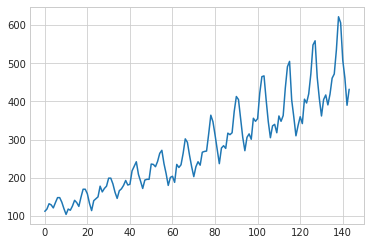

In [11]:
plt.plot(data)
plt.show()

# Train - test - split

In [12]:
alpha = 0.9
N = int(alpha * data.shape[0])
print(N)

129


In [13]:
data_train = data.iloc[:N].copy()
data_test = data.iloc[N:].copy()

data_train.shape, data_test.shape

((129, 1), (15, 1))

# Training

In [15]:
lr = LinearRegression()
ab = AdaBoostRegressor(random_state=123)

In [16]:
for_model_ab = ForecastingModel(ab, params=None)
for_model_lr = ForecastingModel(lr, params=None)

# Linear Regression

In [17]:
for_model_lr.fit(data_train)

/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__ag

In [18]:
predictions_lr = for_model_lr.predict(data_test.shape[0])

/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__ag

/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__ag

/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__ag

/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__ag

/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__ag

/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__ag

/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__ag

/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__ag

/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__ag

/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__ag

/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__ag

/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__ag

/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__ag

/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__ag

In [19]:
predictions_lr

array([ 4.00869355e+002,  3.68973549e+002,  4.93996697e+002,
        2.88495213e+002, -1.37315225e+002, -6.14595521e+003,
       -1.38144299e+006, -6.76900596e+010, -1.54782807e+021,
       -2.80330241e+046, -2.10262700e+107, -2.14236785e+254,
       -2.14236785e+254, -8.65907729e+281, -8.65907729e+281])

# Plotting

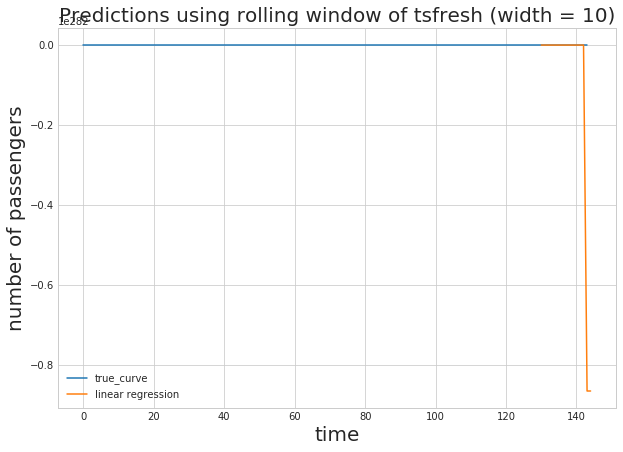

In [20]:
fig = plt.figure(figsize=(10, 7))

plt.plot(data, label = "true_curve")
plt.plot(data_test.index.values + 1, predictions_lr, label = "linear regression")


plt.xlabel("time", size = 20)
plt.ylabel("number of passengers", size = 20)
plt.title("Predictions using rolling window of tsfresh (width = 10)", size = 20)
plt.legend()

plt.show()

# Linear Regression

In [106]:
for_model_lr.fit(data_train, max_timeshift=len(data_train))

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

In [107]:
predictions_lr_new = for_model_lr.predict(data_test.shape[0])

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]WARNING:tsfresh.utilities.dataframe_functions:The columns ['value__fft_coefficient__coeff_65__attr_"abs"'
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

In [108]:
predictions_lr_new

array([363.06132875, 290.61965875, 208.7831435 , 313.67489314,
       372.33964743, 442.06430671, 603.20663683, 263.16094512,
       276.97855755, 283.08267188, 487.39154106, 663.46523318,
       574.3538183 , 440.69607058,  48.85579646])

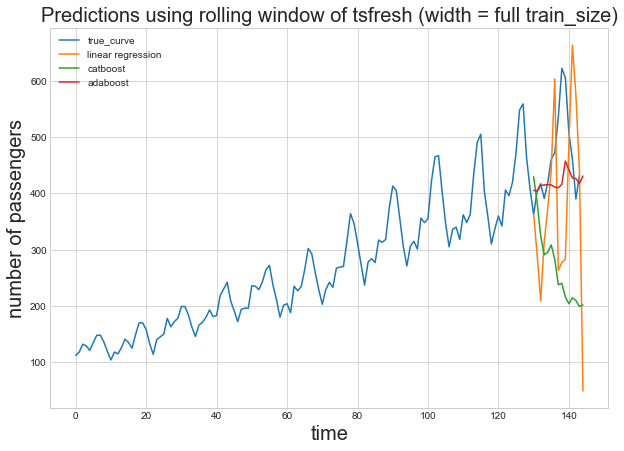

In [109]:
fig = plt.figure(figsize=(10, 7))

plt.plot(data, label = "true_curve")
plt.plot(data_test.index.values + 1, predictions_lr_new, label = "linear regression")

plt.xlabel("time", size = 20)
plt.ylabel("number of passengers", size = 20)
plt.title("Predictions using rolling window of tsfresh (width = full train_size)", size = 20)
plt.legend()

plt.show()

# Checking step-by-step, to prove that everything is fine

In [71]:
# model = LinearRegression()
model = AdaBoostRegressor(random_state = 123)

In [72]:
df_shift, y = make_forecasting_frame(np.append(data_train, 0), kind = "price", 
                            max_timeshift = 10, rolling_direction = 1)
        
X_train = extract_features(df_shift, column_id="id", column_sort="time", 
                                        column_value="value", impute_function=impute, show_warnings=False)
X_train.dropna(axis = 1, inplace = True)
model.fit(X_train[: -1: 1], data_train[1: : 1])

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"_

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123)

In [73]:
cur_pred = model.predict(X_train.iloc[-1][None, :])
cur_pred

array([373.09302326])

In [74]:
data_train_b = np.append(data_train, cur_pred)

In [75]:
df_shift, y = make_forecasting_frame(np.append(data_train_b, 0), kind = "price", 
                            max_timeshift = 10, rolling_direction = 1)
        
X_train = extract_features(df_shift, column_id="id", column_sort="time", 
                                        column_value="value", impute_function=impute, show_warnings=False)
X_train.dropna(axis = 1, inplace = True)
model.fit(X_train[: -1: 1], data_train_b[1: : 1])

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"_

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123)

In [76]:
cur_pred = model.predict(X_train.iloc[-1][None, :])
cur_pred

array([346.37425635])

In [77]:
data_train_b = np.append(data_train_b, cur_pred)

In [78]:
df_shift, y = make_forecasting_frame(np.append(data_train_b, 0), kind = "price", 
                            max_timeshift = 10, rolling_direction = 1)
        
X_train = extract_features(df_shift, column_id="id", column_sort="time", 
                                        column_value="value", impute_function=impute, show_warnings=False)
X_train.dropna(axis = 1, inplace = True)
model.fit(X_train[: -1: 1], data_train_b[1: : 1])

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"_

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123)

In [79]:
cur_pred = model.predict(X_train.iloc[-1][None, :])
cur_pred

array([332.66666667])

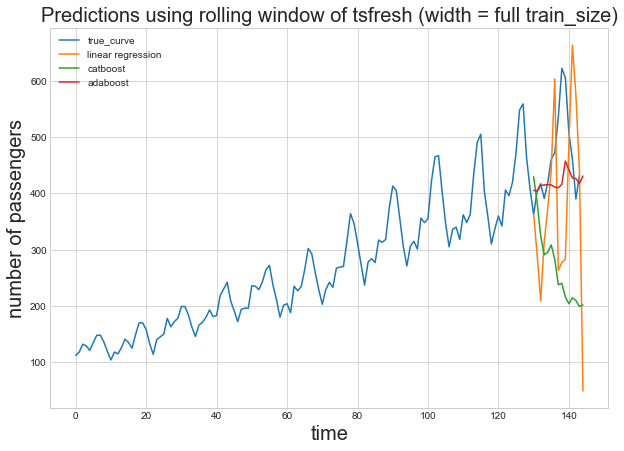

In [110]:
fig = plt.figure(figsize=(10, 7))

plt.plot(data, label = "true_curve")
plt.plot(data_test.index.values + 1, predictions_lr_new, label = "linear regression")
plt.plot(data_test.index.values + 1, predictions_cb_new, label = "catboost")
plt.plot(data_test.index.values + 1, predictions_ab_new, label = "adaboost")

plt.xlabel("time", size = 20)
plt.ylabel("number of passengers", size = 20)
plt.title("Predictions using rolling window of tsfresh (width = full train_size)", size = 20)
plt.legend()

plt.show()

In [113]:
predictions_lr_new

array([363.06132875, 290.61965875, 208.7831435 , 313.67489314,
       372.33964743, 442.06430671, 603.20663683, 263.16094512,
       276.97855755, 283.08267188, 487.39154106, 663.46523318,
       574.3538183 , 440.69607058,  48.85579646])

In [114]:
data_test.values

array([[407.],
       [362.],
       [405.],
       [417.],
       [391.],
       [419.],
       [461.],
       [472.],
       [535.],
       [622.],
       [606.],
       [508.],
       [461.],
       [390.],
       [432.]])

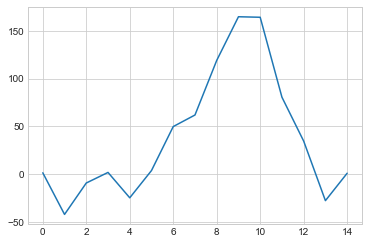

In [117]:
plt.plot(data_test.values.reshape(-1) - predictions_ab_new)

In [ ]:
change, только 